In [6]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
#---The Objective---#
#Estimate the expressivity of the 3467 genes after carefully observing the image of the tissue.
#CAN YOU PLEASE USE THE PRE TRAINED MODEL? THEY ARE NOT HERETICS UNLIKE YOU
#no

#Object : Behold the image of the H&E dyed image and detect how much the 3467 genes are expressed

Importing things

In [7]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchsummary

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Hyperparameter Configuration

In [8]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':50,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':32,
    'SEED':2434
}

Seed unrandomizer

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

Preprocessing

In [10]:
dset_location = "/kaggle/input/medical-ai-1st-dataset"
df = pd.read_csv(dset_location + '/train.csv')

train_len = int(len(df) * 0.9)
train_df = df.iloc[:train_len]
val_df = df.iloc[train_len:]

train_label_vec = train_df.iloc[:,2:].values.astype(np.float32)
val_label_vec = val_df.iloc[:,2:].values.astype(np.float32)

CFG['label_size'] = train_label_vec.shape[1]

Custom Dataset

Type : <class 'numpy.ndarray'>, size = (224, 224, 3)



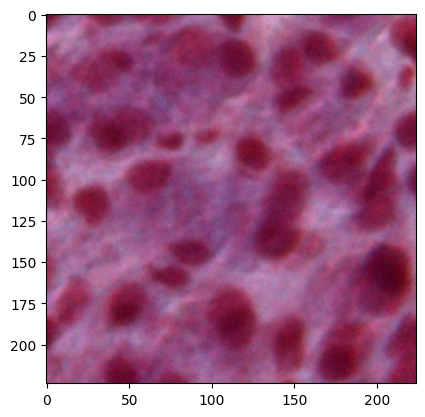

In [11]:
dataidx = 143
Kronk = pd.read_csv("/kaggle/input/medical-ai-1st-dataset/train.csv")
image = cv2.imread("/kaggle/input/medical-ai-1st-dataset" + Kronk['path'][dataidx][1:])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print("Type : {}, size = {}\n".format(type(image), np.shape(image)))

In [12]:
Kronk_labels = Kronk.drop(['ID','path'], axis = 1)
Kronk_labels

,AL645608.7,HES4,TNFRSF18,TNFRSF4,SDF4,ACAP3,INTS11,MXRA8,AL391244.2,LINC01770,...,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-CYB,BX004987.1,AL592183.1
0,0.000506,0.010635,-0.000213,-0.000846,1.512467,0.021131,0.024409,0.004109,0.000301,-0.000176,...,-0.168265,2.858198,3.154686,2.283563,0.417627,2.639062,0.809258,2.053162,-0.000464,-0.000459
1,0.000506,0.010635,-0.000213,-0.000846,1.508787,0.021131,0.024409,0.004109,0.000301,-0.000176,...,-0.168265,2.392524,3.103424,2.462341,0.552690,3.089195,0.578029,2.488428,-0.000464,-0.000459
2,-0.000415,0.005658,-0.000413,0.003148,0.109204,0.013978,0.049823,0.005327,-0.001243,0.000739,...,0.189374,2.730253,3.212037,0.377279,0.340573,3.359260,1.935161,2.502990,0.000598,0.002011
3,-0.000855,0.004366,0.000684,0.000865,0.503090,0.295115,0.303922,-0.004290,0.000451,-0.000140,...,-0.158511,2.753111,2.892158,2.218189,0.677302,2.601587,1.150156,2.198914,0.000307,0.001789
4,0.000506,0.010635,-0.000213,-0.000846,0.905195,0.021131,1.597454,0.004109,0.000301,-0.000176,...,1.097993,3.760496,3.801140,3.460122,1.641039,3.735806,1.666373,3.408605,0.820977,-0.000459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6987,0.000506,0.010635,-0.000213,-0.000846,0.083756,0.021131,0.024409,0.004109,0.000301,-0.000176,...,-0.168265,3.331213,4.122381,2.594354,2.126398,3.521298,1.030052,3.002410,-0.000464,-0.000459
6988,-0.000415,0.005658,-0.000413,0.003148,1.211900,0.013978,0.049823,0.518606,-0.001243,0.000739,...,0.189376,3.561253,3.458018,2.328438,0.853855,3.090364,1.228234,2.704287,0.000598,0.002011
6989,-0.000415,0.005658,-0.000413,0.003148,0.109205,0.013978,0.049823,0.005327,-0.001243,0.000739,...,0.189376,3.265346,3.131831,1.972886,0.340576,2.758763,1.061957,2.912355,0.000598,0.002011
6990,-0.000415,0.005658,-0.000413,0.003148,0.109204,0.013978,0.049823,0.005327,-0.001243,0.000739,...,0.189374,4.216051,4.171533,3.690910,0.340573,3.891024,2.339191,3.676995,0.000598,0.002011


In [13]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms

        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [14]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.HorizontalFlip(p=0.5),
                            A.VerticalFlip(p=0.5),
                            A.Rotate(limit=45, p=0.5),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [15]:
def stringtrimmer(str1):
    str2 = str1[1:]
    return str2


In [16]:
train_dataset = CustomDataset("/kaggle/input/medical-ai-1st-dataset" + train_df['path'].apply(stringtrimmer).values, train_label_vec, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

val_dataset = CustomDataset("/kaggle/input/medical-ai-1st-dataset" + val_df['path'].apply(stringtrimmer).values, val_label_vec, val_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

Model

In [17]:
class SEBlock(nn.Module): #hehe squeeze and excitation funni name
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = nn.functional.adaptive_avg_pool2d(x, 1).view(b, c)
        y = nn.functional.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SEResNet50(nn.Module):
    def __init__(self, gene_size=CFG['label_size']):
        super().__init__()
        self.backbone = models.resnet50(pretrained=True)
        
        self.conv1 = self.backbone.conv1
        self.bn1 = self.backbone.bn1
        self.relu = self.backbone.relu
        self.maxpool = self.backbone.maxpool
        
        self.layer1 = self.backbone.layer1
        self.se1 = SEBlock(256)
        
        self.layer2 = self.backbone.layer2
        self.se2 = SEBlock(512)
        
        self.layer3 = self.backbone.layer3
        self.se3 = SEBlock(1024)
        
        self.layer4 = self.backbone.layer4
        self.se4 = SEBlock(2048)
        
        self.avgpool = self.backbone.avgpool
        self.fc = nn.Linear(2048,gene_size))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.se1(x)
        
        x = self.layer2(x)
        x = self.se2(x)
        
        x = self.layer3(x)
        x = self.se3(x)
        
        x = self.layer4(x)
        x = self.se4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [18]:
class BaseModel(nn.Module):
    def __init__(self, gene_size=CFG['label_size']):
        super(BaseModel, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.modules = list(self.backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*self.modules)
        self.regressor = nn.Sequential(nn.Linear(2048, 1024),
                                       nn.Dropout(0.5),
                                       nn.Linear(1024,gene_size))
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.regressor(x)
        return x

Training et Validation

In [19]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.HuberLoss().to(device)
    
    best_loss = 99999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_loss)
            
        if best_loss > _val_loss:
            best_loss = _val_loss
            best_model = model
    
    return best_model
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
    
    return _val_loss

Le train

In [20]:
model = SEResNet50()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=3, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s] 
100%|██████████| 22/22 [00:07<00:00,  2.93it/s]


Epoch [1], Train Loss : [0.02715] Val Loss : [0.02274]


100%|██████████| 22/22 [00:03<00:00,  6.61it/s]


Epoch [2], Train Loss : [0.02339] Val Loss : [0.02279]


100%|██████████| 22/22 [00:03<00:00,  6.85it/s]


Epoch [3], Train Loss : [0.02323] Val Loss : [0.02266]


100%|██████████| 22/22 [00:03<00:00,  6.89it/s]


Epoch [4], Train Loss : [0.02309] Val Loss : [0.02248]


100%|██████████| 22/22 [00:03<00:00,  6.45it/s]


Epoch [5], Train Loss : [0.02297] Val Loss : [0.02259]


100%|██████████| 22/22 [00:03<00:00,  6.75it/s]


Epoch [6], Train Loss : [0.02291] Val Loss : [0.02303]


100%|██████████| 22/22 [00:03<00:00,  6.64it/s]


Epoch [7], Train Loss : [0.02282] Val Loss : [0.02230]


100%|██████████| 22/22 [00:03<00:00,  6.40it/s]


Epoch [8], Train Loss : [0.02276] Val Loss : [0.02232]


100%|██████████| 22/22 [00:03<00:00,  6.71it/s]


Epoch [9], Train Loss : [0.02272] Val Loss : [0.02224]


100%|██████████| 22/22 [00:03<00:00,  6.64it/s]


Epoch [10], Train Loss : [0.02270] Val Loss : [0.02234]


100%|██████████| 22/22 [00:03<00:00,  6.67it/s]


Epoch [11], Train Loss : [0.02265] Val Loss : [0.02233]


100%|██████████| 22/22 [00:03<00:00,  6.84it/s]


Epoch [12], Train Loss : [0.02251] Val Loss : [0.02211]


100%|██████████| 22/22 [00:03<00:00,  6.64it/s]


Epoch [13], Train Loss : [0.02248] Val Loss : [0.02206]


100%|██████████| 22/22 [00:03<00:00,  6.65it/s]


Epoch [14], Train Loss : [0.02245] Val Loss : [0.02209]


100%|██████████| 22/22 [00:03<00:00,  6.75it/s]


Epoch [15], Train Loss : [0.02245] Val Loss : [0.02211]


100%|██████████| 22/22 [00:03<00:00,  6.61it/s]


Epoch [16], Train Loss : [0.02244] Val Loss : [0.02213]


100%|██████████| 22/22 [00:03<00:00,  6.53it/s]


Epoch [17], Train Loss : [0.02239] Val Loss : [0.02199]


100%|██████████| 22/22 [00:03<00:00,  6.58it/s]


Epoch [18], Train Loss : [0.02237] Val Loss : [0.02201]


100%|██████████| 22/22 [00:03<00:00,  6.55it/s]


Epoch [19], Train Loss : [0.02239] Val Loss : [0.02202]


100%|██████████| 22/22 [00:03<00:00,  6.59it/s]


Epoch [20], Train Loss : [0.02237] Val Loss : [0.02202]


100%|██████████| 22/22 [00:03<00:00,  6.56it/s]


Epoch [21], Train Loss : [0.02236] Val Loss : [0.02201]


100%|██████████| 22/22 [00:03<00:00,  6.56it/s]


Epoch [22], Train Loss : [0.02235] Val Loss : [0.02197]


100%|██████████| 22/22 [00:03<00:00,  6.78it/s]


Epoch [23], Train Loss : [0.02234] Val Loss : [0.02197]


100%|██████████| 22/22 [00:03<00:00,  6.80it/s]


Epoch [24], Train Loss : [0.02235] Val Loss : [0.02198]


100%|██████████| 22/22 [00:03<00:00,  6.77it/s]


Epoch [25], Train Loss : [0.02234] Val Loss : [0.02196]


100%|██████████| 22/22 [00:03<00:00,  6.74it/s]


Epoch [26], Train Loss : [0.02232] Val Loss : [0.02196]


100%|██████████| 22/22 [00:03<00:00,  6.66it/s]


Epoch [27], Train Loss : [0.02234] Val Loss : [0.02196]


100%|██████████| 22/22 [00:03<00:00,  6.53it/s]


Epoch [28], Train Loss : [0.02233] Val Loss : [0.02198]


100%|██████████| 22/22 [00:03<00:00,  6.80it/s]


Epoch [29], Train Loss : [0.02233] Val Loss : [0.02196]


100%|██████████| 22/22 [00:03<00:00,  6.56it/s]


Epoch [30], Train Loss : [0.02233] Val Loss : [0.02199]


100%|██████████| 22/22 [00:03<00:00,  6.79it/s]


Epoch [31], Train Loss : [0.02232] Val Loss : [0.02196]


100%|██████████| 22/22 [00:03<00:00,  6.44it/s]


Epoch [32], Train Loss : [0.02232] Val Loss : [0.02197]


100%|██████████| 22/22 [00:03<00:00,  6.65it/s]


Epoch [33], Train Loss : [0.02234] Val Loss : [0.02196]


100%|██████████| 22/22 [00:03<00:00,  6.70it/s]


Epoch [34], Train Loss : [0.02234] Val Loss : [0.02199]


100%|██████████| 22/22 [00:03<00:00,  6.66it/s]


Epoch [35], Train Loss : [0.02232] Val Loss : [0.02197]


100%|██████████| 22/22 [00:03<00:00,  6.68it/s]


Epoch [36], Train Loss : [0.02232] Val Loss : [0.02201]


100%|██████████| 22/22 [00:03<00:00,  6.71it/s]


Epoch [37], Train Loss : [0.02233] Val Loss : [0.02197]


100%|██████████| 22/22 [00:03<00:00,  6.70it/s]


Epoch [38], Train Loss : [0.02234] Val Loss : [0.02202]


100%|██████████| 22/22 [00:03<00:00,  6.74it/s]


Epoch [39], Train Loss : [0.02233] Val Loss : [0.02197]


100%|██████████| 22/22 [00:03<00:00,  6.63it/s]


Epoch [40], Train Loss : [0.02233] Val Loss : [0.02196]


100%|██████████| 22/22 [00:03<00:00,  6.59it/s]


Epoch [41], Train Loss : [0.02232] Val Loss : [0.02197]


100%|██████████| 22/22 [00:03<00:00,  6.28it/s]


Epoch [42], Train Loss : [0.02233] Val Loss : [0.02196]


100%|██████████| 22/22 [00:03<00:00,  6.55it/s]


Epoch [43], Train Loss : [0.02234] Val Loss : [0.02199]


100%|██████████| 22/22 [00:03<00:00,  6.79it/s]


Epoch [44], Train Loss : [0.02233] Val Loss : [0.02196]


100%|██████████| 22/22 [00:03<00:00,  6.76it/s]


Epoch [45], Train Loss : [0.02232] Val Loss : [0.02197]


100%|██████████| 22/22 [00:03<00:00,  6.68it/s]


Epoch [46], Train Loss : [0.02232] Val Loss : [0.02195]


100%|██████████| 22/22 [00:03<00:00,  6.52it/s]


Epoch [47], Train Loss : [0.02234] Val Loss : [0.02196]


100%|██████████| 22/22 [00:03<00:00,  6.69it/s]


Epoch [48], Train Loss : [0.02233] Val Loss : [0.02197]


100%|██████████| 22/22 [00:03<00:00,  6.67it/s]


Epoch [49], Train Loss : [0.02233] Val Loss : [0.02196]


100%|██████████| 22/22 [00:03<00:00,  6.53it/s]

Epoch [50], Train Loss : [0.02233] Val Loss : [0.02199]


Le inference

In [23]:
test = pd.read_csv('/kaggle/input/medical-ai-1st-dataset/test.csv')

test_dataset = CustomDataset("/kaggle/input/medical-ai-1st-dataset" + test['path'].apply(stringtrimmer).values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(test_loader):
            imgs = imgs.to(device).float()
            pred = model(imgs)
            
            preds.append(pred.detach().cpu())
    
    preds = torch.cat(preds).numpy()

    return preds

preds = inference(infer_model, test_loader, device)

100%|██████████| 72/72 [00:10<00:00,  6.74it/s]


Le Submission

In [24]:
submit = pd.read_csv('/kaggle/input/medical-ai-1st-dataset/sample_submission.csv')
submit.iloc[:, 1:] = np.array(preds).astype(np.float32)
submit.to_csv('/kaggle/working/baseline_submit_13.csv', index=False)

#saving model
torch.save(model.state_dict(), '/kaggle/working/bestmodel_13.pt')